* Python API : https://aws.amazon.com/sdk-for-python/
* Rekognition docs : https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html
* Labels from local file : https://github.com/awsdocs/amazon-rekognition-developer-guide/blob/master/code_examples/python_examples/image/python-detect-labels-local-file.py
* AWS regions https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/Concepts.RegionsAndAvailabilityZones.html
* [Tensorflow component save image function](https://github.com/home-assistant/home-assistant/blob/30841ef4da692cb5d12b26fe08271fdf87c8c992/homeassistant/components/image_processing/tensorflow.py#L231)
* Only return data with an instance cound > 0 in order to limit data to objects

In [1]:
import base64
import boto3
import json
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

FIG_SIZE = (12, 8)

def load_api_secrets(filename):
    """Convenience to load the API key from a json file."""
    try:
        with open(filename, 'r') as fp:
            file_contents = json.load(fp)
            return file_contents
    except Exception as exc:
        print(exc)

In [2]:
boto3.__version__

'1.9.101'

In [3]:
# imageFile='people.jpg'
imageFile='car.jpg'
#imageFile='dog.jpg'
#imageFile='obama.jpg'

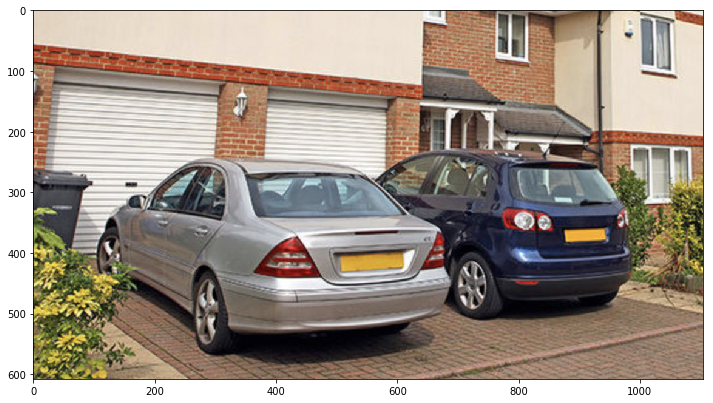

In [4]:
img = plt.imread(imageFile)
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.imshow(img);

We authenticate with amazon using a dict:
    
```python
aws_config = {
        CONF_REGION: config.get(CONF_REGION),
        CONF_ACCESS_KEY_ID: config.get(CONF_ACCESS_KEY_ID),
        CONF_SECRET_ACCESS_KEY: config.get(CONF_SECRET_ACCESS_KEY),
    }
```

We can load these credentials from a json file

In [5]:
aws_config = load_api_secrets("aws-creds.json")
aws_config

{'region_name': 'us-east-1',
 'aws_access_key_id': 'bla',
 'aws_secret_access_key': 'foo'}

My actual credentials are offline

In [6]:
aws_config = load_api_secrets("/Users/robincole/Desktop/aws-creds.json")
#aws_config['region_name'] = 'eu-west-2' # London
print(aws_config['region_name'])
# aws_config

us-east-1


In [7]:
client=boto3.client('rekognition', **aws_config)

In [8]:
try:
    client.detect_labels(Image={'Bytes': b"test"})
except Exception as exc:
    if 'UnrecognizedClientException' in str(exc):
        print(str(exc).split(':')[-1])
    else:
        print("Credentials are OK")

Credentials are OK


## Labels
Post the image file with [detect_labels](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html#Rekognition.Client.detect_labels)

In [9]:
%%time
with open(imageFile, 'rb') as image:
    try:
        response = client.detect_labels(Image={'Bytes': image.read()})
    except Exception as exc:
        print(exc)

CPU times: user 10.4 ms, sys: 5.13 ms, total: 15.6 ms
Wall time: 5.59 s


In [19]:
response

{'Labels': [{'Name': 'Transportation',
   'Confidence': 99.02591705322266,
   'Instances': [],
   'Parents': []},
  {'Name': 'Vehicle',
   'Confidence': 99.02591705322266,
   'Instances': [],
   'Parents': [{'Name': 'Transportation'}]},
  {'Name': 'Automobile',
   'Confidence': 99.02591705322266,
   'Instances': [],
   'Parents': [{'Name': 'Transportation'}, {'Name': 'Vehicle'}]},
  {'Name': 'Car',
   'Confidence': 99.02591705322266,
   'Instances': [{'BoundingBox': {'Width': 0.5424178838729858,
      'Height': 0.5382914543151855,
      'Left': 0.08941608667373657,
      'Top': 0.3893740177154541},
     'Confidence': 99.02591705322266},
    {'BoundingBox': {'Width': 0.4152512550354004,
      'Height': 0.458212286233902,
      'Left': 0.483634352684021,
      'Top': 0.36989983916282654},
     'Confidence': 97.9339370727539}],
   'Parents': [{'Name': 'Transportation'}, {'Name': 'Vehicle'}]},
  {'Name': 'Sedan',
   'Confidence': 91.95348358154297,
   'Instances': [],
   'Parents': [{'Name

In [16]:
labels = {label['Name']: round(label['Confidence'], 2) for label in response['Labels']}
labels

{'Transportation': 99.03,
 'Vehicle': 99.03,
 'Automobile': 99.03,
 'Car': 99.03,
 'Sedan': 91.95,
 'Wheel': 80.34,
 'Machine': 80.34,
 'Tire': 77.33,
 'Bumper': 68.37,
 'Car Wheel': 67.65,
 'Spoke': 67.45,
 'Parking Lot': 64.25,
 'Parking': 64.25,
 'Urban': 59.75,
 'Alloy Wheel': 59.65,
 'License Plate': 57.96}

In [25]:
MOCK_RESPONSE = {'Labels': [
  {'Name': 'Car',
   'Confidence': 99.025,
   'Instances': [{'BoundingBox': 'data',
     'Confidence': 99.025},
    {'BoundingBox': 'data',
     'Confidence': 97.933}],
   'Parents': [{'Name': 'Transportation'}, {'Name': 'Vehicle'}]},
]}

In [26]:
def parse_labels(response):
    """Parse the API labels data, returning objects only."""
    return {label['Name']: round(label['Confidence'], 2) for label in response['Labels']}

In [27]:
parse_labels(MOCK_RESPONSE)

{'Car': 99.03}

In [18]:
target = 'Car'
if target in labels.keys():
    print(labels[target])

99.03


In [11]:
print('Detected labels in ' + imageFile)    
for label in response['Labels']:
    if len(label['Instances']) > 0:
        print (label['Name'] + ' : ' + str(label['Confidence']))

Detected labels in car.jpg
Car : 99.02591705322266


In [11]:
response['Labels'][8]

{'Name': 'Footwear',
 'Confidence': 99.77645874023438,
 'Instances': [],
 'Parents': [{'Name': 'Clothing'}]}

In [12]:
def parse_labels(response):
    """Parse the API labels data, returning objects only."""
    return {label['Name']: round(label['Confidence'], 2)
            for label in response['Labels'] if len(label['Instances']) > 0}

In [13]:
parse_labels(response)

{'Jeans': 99.99, 'Person': 99.95, 'Shoe': 99.78}

In [14]:
def get_label_data(response, target='Person'):
    """Get label data."""
    for label in response['Labels']:
        if label['Name'] == target:
            data = {}
            data['Confidence'] = round(label['Confidence'], 2)
            data['Instances'] = len(label['Instances'])
            
            bounding_boxes = []
            for instance in label['Instances']:
                bounding_boxes.append(instance['BoundingBox'])
            
            data['bounding_boxes'] = bounding_boxes
            return data
    return {'Instances':0, 'Confidence':None, 'bounding_boxes':None}

In [15]:
data = get_label_data(response, target='Person')

In [19]:
bounding_boxes = data['bounding_boxes']

## Draw bounding boxes
Really we want to implement this at the platform level, not in the component

In [20]:
img = plt.imread(imageFile)

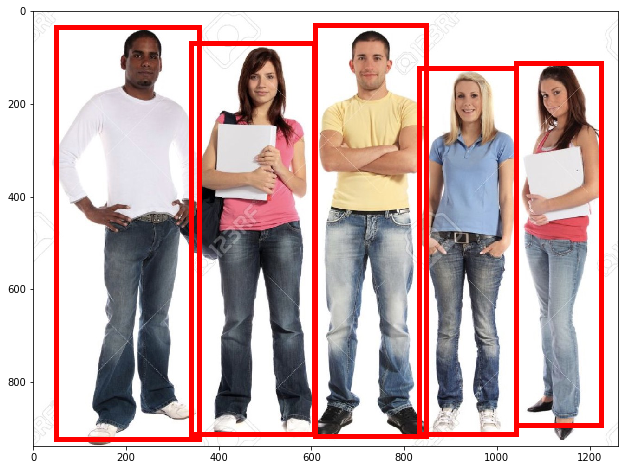

In [21]:
img = plt.imread(imageFile)
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.imshow(img);

# Get the shape of the image in pixels
img_height = img.shape[0]
img_width = img.shape[1]

for box in bounding_boxes:
    x = box['Left']*img_width
    y = box['Top']*img_height
    width = box['Width']*img_width
    height = box['Height']*img_height

    rect = patches.Rectangle((x,y), width, height, linewidth=5, edgecolor='r', facecolor='none')
    ax.add_patch(rect);

plt.savefig('boxed_image.jpg')